In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-captcha-recognition/sample_submission.csv
/kaggle/input/sf-captcha-recognition/data/images_unlabeled.npy
/kaggle/input/sf-captcha-recognition/data/images.npy
/kaggle/input/sf-captcha-recognition/data/labels.npy
/kaggle/input/sf-captcha-recognition/data/images_sub.npy


In [8]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as O
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
import warnings 
warnings.filterwarnings("ignore")

2024-08-15 10:05:16.702335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 10:05:16.702436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 10:05:16.832963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-7d084ed0-4ddd-50c5-7fc7-7df225d9c403)


In [10]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
#загрузка данных
import numpy as np
images = np.load('/kaggle/input/sf-captcha-recognition/data/images.npy')
labels = np.load('/kaggle/input/sf-captcha-recognition/data/labels.npy')
images_sub = np.load('/kaggle/input/sf-captcha-recognition/data/images_sub.npy')
sample_submission = pd.read_csv('/kaggle/input/sf-captcha-recognition/sample_submission.csv')

In [14]:
images.shape

(20000, 48, 48, 3)

In [15]:
labels.shape

(20000,)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels, test_size=0.1, random_state=42)

In [ ]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    rotation_range = 50,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [17]:
print(f'Тренировочные данные:{X_train.shape}, {y_train.shape}')
print(f'Тестовые данные:{X_test.shape}, {y_test.shape}')

Тренировочные данные:(18000, 48, 48, 3), (18000,)
Тестовые данные:(2000, 48, 48, 3), (2000,)


In [18]:
NUM_CLASSES = 26
cifar10_classes = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T",\
                   "U","V","W","X","Y","Z"]

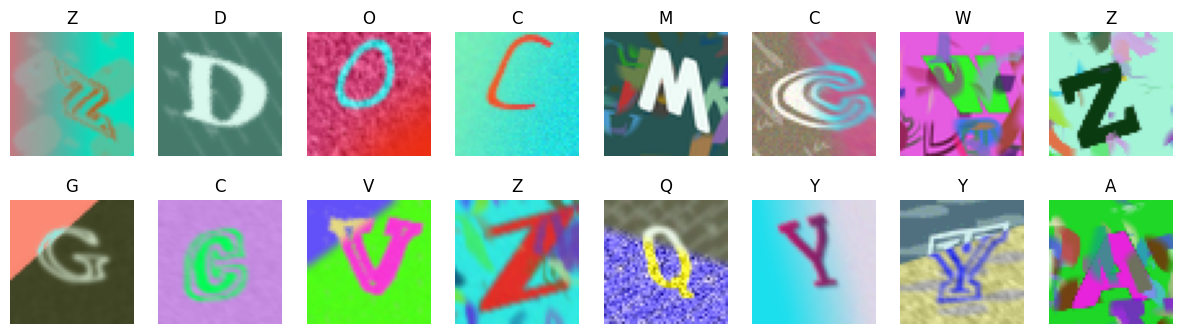

In [20]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_train[random_index])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [21]:
# нормализуем входы
X_train = X_train.astype('float32') / 255 - 0.5
X_test = X_test.astype('float32') / 255 - 0.5

# нормализуем входы
images_sub = images_sub.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [22]:
X_train.shape[1:]

(48, 48, 3)

останавливать досрочно процесс обучения, если показатель качества (функция потерь) снижается очень медленно. Возможно, мы оказались на каком-то высоком плато и алгоритм backpropagation не может выйти с этого уровня на более низкий и достичь лучших показателей при обучении. 

[Тонкая настройка и контроль процесса обучения через метод fit()](https://proproprogs.ru/tensorflow/keras-tonkaya-nastroyka-kontrol-processa-obucheniya-cherez-metod-fit)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.005, patience=1, verbose=1)
]

In [23]:
def make_relu_bn_model():
    model = M.Sequential()

    # model layer 1
    model.add(L.Convolution2D(128, kernel_size=3, strides=1, input_shape=X_train.shape[1:], activation='relu', padding='same',))
    model.add(L.BatchNormalization())
    model.add(L.Convolution2D(128, kernel_size=3, strides=1, activation='relu', padding='same',))
    model.add(L.BatchNormalization())

    # Pooling layer 1
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.2))

    # model and pooling layer 2
    model.add(L.Convolution2D(256, kernel_size=3, strides=1, activation='relu', padding='same',))
    model.add(L.BatchNormalization())
    model.add(L.Convolution2D(256, kernel_size=3, strides=1, activation='relu', padding='same',))
    model.add(L.BatchNormalization())

    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.3))

    # model and pooling layer 3.
    model.add(L.Convolution2D(512, kernel_size=3, strides=1, activation='relu', padding='same',))
    model.add(L.BatchNormalization())
    model.add(L.Convolution2D(512, kernel_size=3, strides=1, activation='relu', padding='same',))
    model.add(L.BatchNormalization())

    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.3))


    # Flattening
    model.add(L.Flatten())

    # Full connection
    model.add(L.Dense(512, activation='relu'))
    model.add(L.Dropout(0.25))
    model.add(L.Dense(26, activation='softmax'))
    
    return model

In [ ]:
def make_relu_bn_model():
    model = Sequential()
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D(pool_size = 2, padding = 'same'))
    model.add(L.Dropout(rate=0.25))
    model.add(L.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(L.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D(pool_size = 2, padding = 'same'))
    model.add(L.Dropout(rate=0.25))
    model.add(L.Flatten())
#     model.add(L.Dense(256, activation='relu'))
#     model.add(BatchNormalization())
    model.add(L.Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(L.Dropout(rate=0.35))
    model.add(L.Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(L.Dropout(rate=0.65))
    model.add(L.Dense(26, activation='softmax'))

    return model

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [24]:
# учим bn adam
def train_model(make_model_func=make_relu_bn_model):
  BATCH_SIZE = 64
  EPOCHS = 23

  K.clear_session()
  trained_model = make_model_func()
  adam = Adam(learning_rate=0.005)

  trained_model.compile(
      loss='categorical_crossentropy',
      optimizer="adam",
      metrics=['accuracy']
  )
    
  history = trained_model.fit(
      X_train, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(X_test, y_test2),
      shuffle=False
  )
  
  plt.plot(history.history['accuracy'])

  plt.plot(history.history['val_accuracy'])

  plt.title('Model accuracy')

  plt.ylabel('loc=Accuracy')

  plt.xlabel('Epoch')

  plt.legend(['Train', 'Test'], loc='upper left')

  plt.show()

  predicts = np.argmax(trained_model.predict(X_test), axis = 1)
  print('Test Accuracy: ', accuracy_score(y_test, predicts))
  return trained_model

In [25]:
model = make_relu_bn_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        13,33

 Total params: 14,034,586 (53.54 MB)

 Trainable params: 14,031,002 (53.52 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/23
  3/282 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.0304 - loss: 12.4705  

I0000 00:00:1723716424.326449     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723716424.349994     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.0474 - loss: 5.6883

W0000 00:00:1723716447.343775     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


282/282 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step - accuracy: 0.0474 - loss: 5.6822 - val_accuracy: 0.0460 - val_loss: 3.3198
Epoch 2/23
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.0578 - loss: 3.1819 - val_accuracy: 0.0810 - val_loss: 3.1108
Epoch 3/23
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.1000 - loss: 2.9946 - val_accuracy: 0.2230 - val_loss: 2.4816
Epoch 4/23
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.2089 - loss: 2.5093 - val_accuracy: 0.4525 - val_loss: 1.7727
Epoch 5/23
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.3295 - loss: 2.0732 - val_accuracy: 0.6110 - val_loss: 1.2503
Epoch 6/23
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.4804 - loss: 1.5818 - val_accuracy: 0.7105 - val_loss: 0.9169
Epoch 7/23
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.6031 - loss: 1.2005 - val_accuracy: 0.7400 - val_loss: 0.8176
Epoch 8/23
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.6952 - loss: 0.9201 - val_accurac

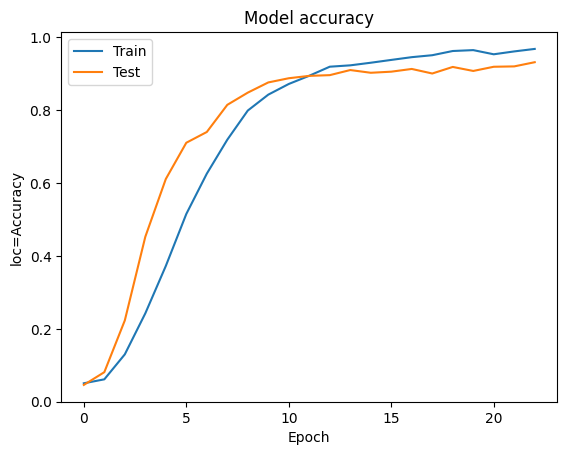

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Test Accuracy:  0.9315
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


In [26]:
# учим bn adam архитектуру
labels_sub = train_model().predict(images_sub)

In [27]:
sample_submission['Category'] = labels_sub.argmax(axis = 1)

In [28]:
sample_submission['Category'].unique()

array([19,  8, 14, 12, 10,  7,  5, 17, 23, 22,  3,  4,  0, 13,  2, 11,  1,
       24, 16, 15, 20, 18,  9, 25,  6, 21])

In [ ]:
sample_submission['Category'].value_counts()

In [30]:
sample_submission.to_csv('sample_submission', index=False)

In [ ]:
sample_submission